In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utmhikari/doubanmovieshortcomments")

print("Path to dataset files:", path)

c:\Users\sgp\miniconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\sgp\.cache\kagglehub\datasets\utmhikari\doubanmovieshortcomments\versions\7


In [3]:
import pandas as pd
import re
import jieba
import hanlp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.nn.utils.rnn import pad_sequence

In [21]:
df = pd.read_csv(path + "/DMSC.csv")
df.head()

,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like
0,0,Avengers Age of Ultron,复仇者联盟2,2017-01-22,1,然潘,2015-05-13,3,连奥创都知道整容要去韩国。,2404
1,1,Avengers Age of Ultron,复仇者联盟2,2017-01-22,2,更深的白色,2015-04-24,2,非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...,1231
2,2,Avengers Age of Ultron,复仇者联盟2,2017-01-22,3,有意识的贱民,2015-04-26,2,2015年度最失望作品。以为面面俱到，实则画蛇添足；以为主题深刻，实则老调重弹；以为推陈出...,1052
3,3,Avengers Age of Ultron,复仇者联盟2,2017-01-22,4,不老的李大爷耶,2015-04-23,4,《铁人2》中勾引钢铁侠，《妇联1》中勾引鹰眼，《美队2》中勾引美国队长，在《妇联2》中终于...,1045
4,4,Avengers Age of Ultron,复仇者联盟2,2017-01-22,5,ZephyrO,2015-04-22,2,虽然从头打到尾，但是真的很无聊啊。,723


In [22]:
df.isnull().sum()

ID                 0
Movie_Name_EN      0
Movie_Name_CN      0
Crawl_Date         0
Number             0
Username         173
Date               0
Star               0
Comment            0
Like               0
dtype: int64

In [23]:
# 数据预处理
def data_preprocess(df):
    df = df[['Star','Comment']].copy()
    df['label'] = df['Star'].apply(lambda x:1 if x>=4 else 0 if x<=2 else -1)
    df = df[df['label'] != -1].reset_index(drop=True)
    df.drop(columns=['Star'], inplace=True)

    return df


In [24]:
# 统计数据分布
df = data_preprocess(df)
df['label'] = df['label'].astype(int)
df['label'].value_counts()


label
1    1279892
0     370605
Name: count, dtype: int64

In [25]:
# 文本处理

remove_punctuation = re.compile(r'[^\w\s]')
remove_digits = re.compile(r'\d+')

stop_words = set()
with open("./data/stopwords.txt", 'r', encoding='utf-8') as f:
        for line in f:
            stop_words.add(line.strip())


def text_cleaning(text, tokenizer):
    text = remove_punctuation.sub('', text)
    text = remove_digits.sub('', text)

    if tokenizer == 'jieba':
        words = jieba.lcut(text)
    elif tokenizer == 'hanlp':
        hanlp_preprocessor = hanlp.pipeline('tok/fine')
        words = hanlp_preprocessor(text)
    else:
        raise ValueError("Unsupported tokenizer")

    # 去除停用词
    words = [word for word in words if word not in stop_words]

    return words

In [26]:
# 对df['Comment']用 hanlp 进行文本分词处理
# df['Comment'] = df['Comment'].apply(lambda x: text_cleaning(x, 'hanlp'))
# df.head()

In [27]:
# 对df['Comment']用 jeiba 进行文本分词处理
df['Comment'] = df['Comment'].apply(lambda x: text_cleaning(x, 'jieba'))
df.head()

,Comment,label
0,"[ , 失望, 剧本, 敷衍了事, 主线, 剧情, 突破, 理解, 人物, 缺乏, 动机, ...",0
1,"[ , 年度, 失望, 作品, 面面俱到, 实则, 画蛇添足, 主题深刻, 实则, 老调重弹...",0
2,"[ , 铁人, 中, 勾引, 钢铁, 侠, 妇联, 中, 勾引, 鹰眼, 美队, 中, 勾引...",1
3,"[ , 打到, 尾, 真的, 无聊]",0
4,"[ , 一颗, 彩蛋, 降一星, 外加, 漫威, 编剧, 有心无力, 复仇者, 联盟, 只能...",0


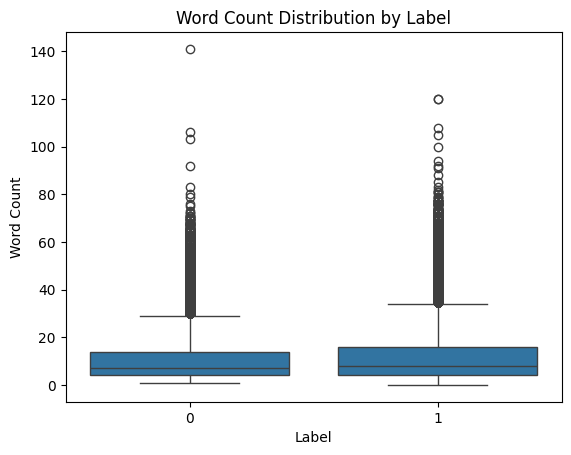

In [28]:
# 统计comment不同label对应的每一列词语的数量，绘制箱型图
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplot(df):
    # 统计不同label对应的每一列词语的数量
    df['word_count'] = df['Comment'].apply(lambda x: len(x))
    sns.boxplot(x='label', y='word_count', data=df)
    plt.title('Word Count Distribution by Label')
    plt.xlabel('Label')
    plt.ylabel('Word Count')
    plt.show()

plot_boxplot(df)


In [29]:
# 取词数在[10,60]的comment
df = df[(df['word_count'] >= 10) & (df['word_count'] <= 60)].reset_index(drop=True)
df['label'].value_counts()

label
1    548362
0    140176
Name: count, dtype: int64

(array([61954.,     0., 53790.,     0., 47506.,     0., 41987.,     0.,
        37709.,     0., 33539.,     0., 30900.,     0., 27784.,     0.,
        25543.,     0., 23053.,     0., 21226.,     0., 19734.,     0.,
        18457.,     0., 16887.,     0., 15818.,     0., 14614.,     0.,
        13992.,     0., 12955.,     0., 12475.,     0., 11700.,     0.,
        11039.,     0., 10684.,     0., 10338.,     0., 10407.,     0.,
         9984.,     0.,  9660.,     0.,  9654.,     0.,  9036.,     0.,
         8984.,     0.,  8291.,     0.,  7607.,     0.,  6727.,     0.,
         6155.,     0.,  5211.,     0.,  4442.,     0.,  3695.,     0.,
         3040.,     0.,  2475.,     0.,  1929.,     0.,  1594.,     0.,
         1336.,     0.,   983.,     0.,   794.,     0.,   682.,     0.,
          538.,     0.,   458.,     0.,   338.,     0.,   284.,     0.,
          228.,     0.,   182.,   140.]),
 array([10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ,
        15.5, 16. , 

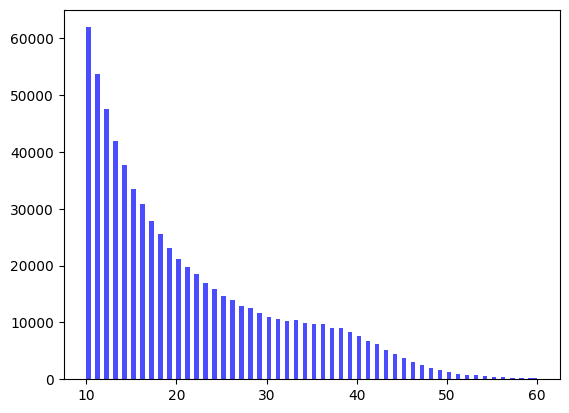

In [30]:
plt.hist(df['word_count'], bins=100, color='blue', alpha=0.7)

In [31]:
# 构建词汇表，加入处理OOV（词表外词汇）
word2idx = {}
def build_from_df(df):
    vocab = set()
    for comment in df['Comment']:
        vocab.update(comment)

    vocab = list(vocab - {'PAD', 'UNK'})  # 确保不会重复
    vocab = ['PAD', 'UNK'] + vocab        # 手动保证 PAD 是 index 0，UNK 是 1
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    return word2idx


word2idx = build_from_df(df)
# 词汇表大小
vocab_size = len(word2idx)
print("Vocabulary Size:", vocab_size)
# 词汇表前10个词和对应的索引
print("Vocabulary:", list(word2idx.items())[:10])


Vocabulary Size: 276218
Vocabulary: [('PAD', 0), ('UNK', 1), ('盗走', 2), ('纯用', 3), ('书架子', 4), ('手触', 5), ('城起', 6), ('残带', 7), ('小气鬼', 8), ('接地', 9)]


In [32]:
# 将评论转换为索引
def comments_to_indices(df, word2idx):
    df['Comment'] = df['Comment'].apply(lambda x: [word2idx[word] for word in x])
    return df

df = comments_to_indices(df, word2idx)
df.head()

,Comment,label,word_count
0,"[108268, 8231, 258275, 57864, 95104, 170207, 1...",0,41
1,"[108268, 9597, 8231, 53644, 215695, 260389, 17...",0,33
2,"[108268, 192684, 45725, 104168, 72194, 39303, ...",1,35
3,"[108268, 58671, 123809, 215999, 250883, 2816, ...",0,41
4,"[108268, 219931, 4425, 160751, 135253, 108268,...",1,42


In [33]:
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence

# 将评论转换为 NumPy 数组
comments_array = df['Comment'].tolist()  # 保持为列表形式
labels_array = np.array(df['label'].tolist(), dtype=np.int64)  # 转换为整数类型的 NumPy 数组

# 将评论列表转换为张量，并进行填充
comments = pad_sequence([torch.tensor(c, dtype=torch.long) for c in comments_array], 
                               batch_first=True, padding_value=0)  # 填充为相同长度
labels = torch.tensor(labels_array, dtype=torch.long)  

print("Padded Comments Tensor Shape:", comments.shape)
print("Labels Tensor Shape:", labels.shape)


Padded Comments Tensor Shape: torch.Size([688538, 60])
Labels Tensor Shape: torch.Size([688538])


In [34]:
# 保存数据
torch.save(comments, './data/comments_jieba.pkl')
torch.save(labels, './data/labels_jieba.pkl')

In [35]:
# # 保存数据
# torch.save(comments, './data/comments_hanlp.pt')
# torch.save(labels, './data/labels_hannlp.pt')

tensorboard --logdir=./logs